<a href="https://colab.research.google.com/github/Omkaar-Kasodekar/Netflix-Recommendation-System/blob/main/Netflix_Reccomendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Netflix Recommendation System**

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

# VADER lexicon
nltk.download('vader_lexicon', quiet=True)

True

Fetch the TMDB API Key

In [2]:
# TMDB API Setup
def get_api_key(filename="//content//drive//MyDrive//TMDB_API_KEY.txt"):
    try:
        with open(filename, "r") as file:
            api_key = file.readline().strip()
            if not api_key:
                raise ValueError("API key file is empty!")
            return api_key
    except FileNotFoundError:
        print("⚠️ Error: API key file not found!")
        return None
    except Exception as e:
        print(f"⚠️ Error reading API key: {e}")
        return None

# Fetch API key
TMDB_API_KEY = get_api_key()

# Check if API key was retrieved successfully
if TMDB_API_KEY:
    print("✅ API key loaded successfully!")
else:
    print("❌ Failed to load API key. Please check the file.")

TMDB_BASE_URL = "https://api.themoviedb.org/3"
NETFLIX_PROVIDER_ID = 8  # TMDB provider ID for Netflix

# Files to locally store data
MOVIES_CSV_FILE = "netflix_movies.csv" # File for movies
SERIES_CSV_FILE = "netflix_series.csv" # File for series
USERS_FOLDER = "//content//drive//MyDrive//Users"  # Folder to store user data
ALL_USERS_DATA_FILE = "//content//drive//MyDrive//all_users_data.csv"  # Combined data file

✅ API key loaded successfully!


In [19]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Fetch Genre mappings from TMDB API
def get_genre_mapping(media_type="movie"):
    url = f"{TMDB_BASE_URL}/genre/{media_type}/list?api_key={TMDB_API_KEY}&language=en-US"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching {media_type} genres: {response.status_code}")
        return {}

    genres_data = response.json().get("genres", [])
    return {genre["id"]: genre["name"] for genre in genres_data}  # Mapping {id: name}

Fetch all **Netflix movies** and locally store it in a CSV file

In [21]:
def fetch_netflix_movies():
    all_movies = []
    page = 1
    genre_mapping = get_genre_mapping("movie")  # Get {genre_id: genre_name} mapping

    while True:
        url = f"{TMDB_BASE_URL}/discover/movie?api_key={TMDB_API_KEY}&with_watch_providers={NETFLIX_PROVIDER_ID}&watch_region=US&page={page}"
        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error fetching movies (Page {page}): {response.status_code}")
            break

        data = response.json()
        movies = data.get("results", [])
        if not movies:
            break

        for movie in movies:
            genre_names = [genre_mapping.get(genre_id, "Unknown") for genre_id in movie.get("genre_ids", [])]

            all_movies.append({
                "id": movie["id"],
                "title": movie["title"],
                "year": movie.get("release_date", "N/A")[:4],
                "overview": movie.get("overview", "No description available."),
                "genres": ", ".join(genre_names),
                "popularity": movie.get("popularity", 0)
            })

        page += 1
        if page > data["total_pages"]:
            break

        time.sleep(1)

    movies_df = pd.DataFrame(all_movies)
    movies_df.to_csv(MOVIES_CSV_FILE, index=False)
    print(f"\n{len(movies_df)} Netflix movies saved to '{MOVIES_CSV_FILE}'.")

    return movies_df

Fetch all **Netflix series** and locally store it in a CSV file

In [22]:
def fetch_netflix_series():
    all_series = []
    page = 1
    genre_mapping = get_genre_mapping("tv")

    while True:
        url = f"{TMDB_BASE_URL}/discover/tv?api_key={TMDB_API_KEY}&with_watch_providers={NETFLIX_PROVIDER_ID}&watch_region=US&page={page}"
        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error fetching series (Page {page}): {response.status_code}")
            break

        data = response.json()
        series = data.get("results", [])
        if not series:
            break

        for show in series:
            genre_names = [genre_mapping.get(genre_id, "Unknown") for genre_id in show.get("genre_ids", [])]

            all_series.append({
                "id": show["id"],
                "title": show["name"],
                "year": show.get("first_air_date", "N/A")[:4],
                "overview": show.get("overview", "No description available."),
                "genres": ", ".join(genre_names),
                "popularity": show.get("popularity", 0)
            })

        page += 1
        if page > data["total_pages"]:
            break

        time.sleep(1)

    series_df = pd.DataFrame(all_series)
    series_df.to_csv(SERIES_CSV_FILE, index=False)
    print(f"\n{len(series_df)} Netflix series saved to '{SERIES_CSV_FILE}'.")

    return series_df

Load data from CSV or Fetch from API (if data not found in csv)

In [23]:
def load_or_fetch_movies():
    if os.path.exists(MOVIES_CSV_FILE):
        print(f"\nLoading movies from '{MOVIES_CSV_FILE}'...")
        return pd.read_csv(MOVIES_CSV_FILE)
    else:
        print("\nFetching Netflix movies from TMDB API...")
        return fetch_netflix_movies()

def load_or_fetch_series():
    if os.path.exists(SERIES_CSV_FILE):
        print(f"\nLoading series from '{SERIES_CSV_FILE}'...")
        return pd.read_csv(SERIES_CSV_FILE)
    else:
        print("\nFetching Netflix series from TMDB API...")
        return fetch_netflix_series()

def save_user_data(username, data):
    filename = os.path.join(USERS_FOLDER, f"{username}_ratings.csv")
    pd.DataFrame(data).to_csv(filename, index=False)

def load_user_data(username):
    filename = os.path.join(USERS_FOLDER, f"{username}_ratings.csv")
    if os.path.exists(filename):
        return pd.read_csv(filename)
    else:
        return pd.DataFrame(columns=["title", "rating", "review"])
def update_combined_user_data(username, data):
    # Load existing combined data
    if os.path.exists(ALL_USERS_DATA_FILE):
        combined_data = pd.read_csv(ALL_USERS_DATA_FILE)
    else:
        combined_data = pd.DataFrame(columns=["username", "title", "rating", "review"])

    # Add username to the data
    data['username'] = username

    # Append new user's data to the combined data
    combined_data = pd.concat([combined_data, data], ignore_index=True)

    # Save updated combined data
    combined_data.to_csv(ALL_USERS_DATA_FILE, index=False)

Add user data

In [7]:
def add_user_rating(username):
    title = input("Enter the title of the movie/series: ")
    rating = int(input("Enter your rating (out of 10): "))
    review = input("Enter your review: ")

    user_data = load_user_data(username)
    new_row = pd.DataFrame({"title": [title], "rating": [rating], "review": [review]})
    user_data = pd.concat([user_data, new_row], ignore_index=True)
    save_user_data(username, user_data)
    update_all_users_data()

Sentiment analysis

In [24]:
def analyze_sentiment(user_data):
    if user_data.empty or 'review' not in user_data.columns:
        print("No reviews found for sentiment analysis.")
        return 0  # Return a neutral sentiment if no reviews

    sentiment_scores = []
    for review in user_data["review"]:
        sentiment = sia.polarity_scores(review)
        sentiment_scores.append(sentiment["compound"])

    # Calculate average sentiment score
    avg_sentiment = np.mean(sentiment_scores)

    return avg_sentiment

**TF-IDF** and **Cosine Similarity** on positively sentimented data

In [ ]:
def get_recommendations(username, movies_df, series_df):
    user_data = load_user_data(username)

    if user_data.empty:
        print("No ratings found for this user.")
        return pd.DataFrame()

    # Analyze sentiment for each movie/series
    sentiment_scores = []
    for title, group in user_data.groupby('title'):
        reviews = group['review'].tolist()
        sentiment = np.mean([sia.polarity_scores(review)["compound"] for review in reviews])
        sentiment_scores.append((title, sentiment))

    # Filter positively sentimented movies/series
    positive_titles = [title for title, score in sentiment_scores if score > 0.2]

    if not positive_titles:
        print("No positively sentimented movies/series found.")
        return pd.DataFrame()

    # Combine movie and series data
    combined_df = pd.concat([movies_df, series_df], ignore_index=True)

    # Filter combined data for positively sentimented titles
    positive_df = combined_df[combined_df['title'].isin(positive_titles)]

    if positive_df.empty:
        print("No matching positively sentimented movies/series found in the dataset.")
        return pd.DataFrame()

    # TF-IDF Vectorization on the entire dataset
    combined_df["combined"] = combined_df["genres"].fillna("") + " " + combined_df["overview"].fillna("")
    tfidf = TfidfVectorizer(stop_words="english")
    tfidf_matrix = tfidf.fit_transform(combined_df["combined"])

    # Get indices of positively sentimented movies/series
    positive_indices = [combined_df[combined_df['title'] == title].index[0] for title in positive_titles]

    # Compute cosine similarity between all items and positively sentimented items
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Aggregate similarity scores for each item based on positive items
    similar_scores = np.mean(cosine_sim[positive_indices], axis=0)

    # Add similarity scores to the DataFrame
    combined_df['similarity_score'] = similar_scores

    # Sort the DataFrame by similarity score in descending order
    sorted_df = combined_df.sort_values(by='similarity_score', ascending=False)

    # Exclude the positively rated movies from recommendations
    recommendations = sorted_df[~sorted_df['title'].isin(positive_titles)]

    return recommendations[["title", "year", "genres", "overview", "similarity_score"]].head(5)


def display_results(results, title):
    if results.empty:
        print(f"\nNo results found for '{title}'. Try a different search.")
    else:
        print(f"\nResults for '{title}':")
        print(tabulate(results, headers="keys", tablefmt="fancy_grid", showindex=False))

# Main Menu
movies_df = load_or_fetch_movies()  # Load movies
series_df = load_or_fetch_series()  # Load series

Search Movies and Series by keyword(s)

In [10]:
def search_content(keyword, content_type="both"):
    results = pd.DataFrame()

    if content_type in ["both", "movies"]:
        movie_results = movies_df[
            (movies_df["title"].str.contains(keyword, case=False, na=False)) |
            (movies_df["overview"].str.contains(keyword, case=False, na=False))
        ]
        results = pd.concat([results, movie_results], ignore_index=True)

    if content_type in ["both", "series"]:
        series_results = series_df[
            (series_df["title"].str.contains(keyword, case=False, na=False)) |
            (series_df["overview"].str.contains(keyword, case=False, na=False))
        ]
        results = pd.concat([results, series_results], ignore_index=True)

    return results[["title", "year", "genres", "overview"]]

def update_all_users_data():
    all_data = pd.DataFrame()
    for filename in os.listdir(USERS_FOLDER):
        if filename.endswith("_ratings.csv"):
            username = filename.replace("_ratings.csv", "")
            filepath = os.path.join(USERS_FOLDER, filename)
            user_data = pd.read_csv(filepath)
            user_data["username"] = username  # Add username column
            all_data = pd.concat([all_data, user_data], ignore_index=True)

    # Save combined data
    all_data.to_csv(ALL_USERS_DATA_FILE, index=False)
    print(f"✅ Updated combined user data in '{ALL_USERS_DATA_FILE}'.")

User Interface

In [29]:
while True:
    print("\n ===================== MENU =====================")
    print("1️⃣ Add a rating")
    print("2️⃣ Get recommendations")
    print("3️⃣ Search for movies or series")
    print("4️⃣ Refresh Netflix movie & series data from TMDB API")
    print("5️⃣ Exit")
    print("===================================================")

    choice = input("➡️ Enter your choice (1/2/3/4/5): ")

    if choice == "1":
        username = input("Enter your username: ")
        add_user_rating(username)

    elif choice == "2":
        username = input("Enter your username: ")
        recommendations = get_recommendations(username, movies_df, series_df)
        display_results(recommendations, "Recommendations:")

    elif choice == "3":
        search_keyword = input("\n🔍 Enter a keyword to search for movies or series: ").strip()
        results = search_content(search_keyword, content_type="both")

        display_results(results, search_keyword)

    elif choice == "4":
        print("\n🌐 Fetching fresh Netflix movie & series data from TMDB API...")
        movies_df = fetch_netflix_movies()
        series_df = fetch_netflix_series()
        print("\n✅ Movie & Series data refreshed successfully!")
        update_all_users_data() # Update combined data after refresh


    elif choice == "5":
        print("\n Exiting... ")
        time.sleep(2)
        print("Thank You!!!")
        break

    else:
        print("\n⚠️ Invalid choice. Please enter a valid option (1-5).")


 ===================== MENU =====================
1️⃣ Add a rating
2️⃣ Get recommendations
3️⃣ Search for movies or series
4️⃣ Refresh Netflix movie & series data from TMDB API
5️⃣ Exit
➡️ Enter your choice (1/2/3/4/5): Sahil

⚠️ Invalid choice. Please enter a valid option (1-5).

 ===================== MENU =====================
1️⃣ Add a rating
2️⃣ Get recommendations
3️⃣ Search for movies or series
4️⃣ Refresh Netflix movie & series data from TMDB API
5️⃣ Exit
➡️ Enter your choice (1/2/3/4/5): 2
Enter your username: Sahil

Results for 'Recommendations:':
╒═════════════════════════════════╤════════╤════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════╕
│ title                           │   year │ genres                             │ overview                                                                                           

### Data Analysis

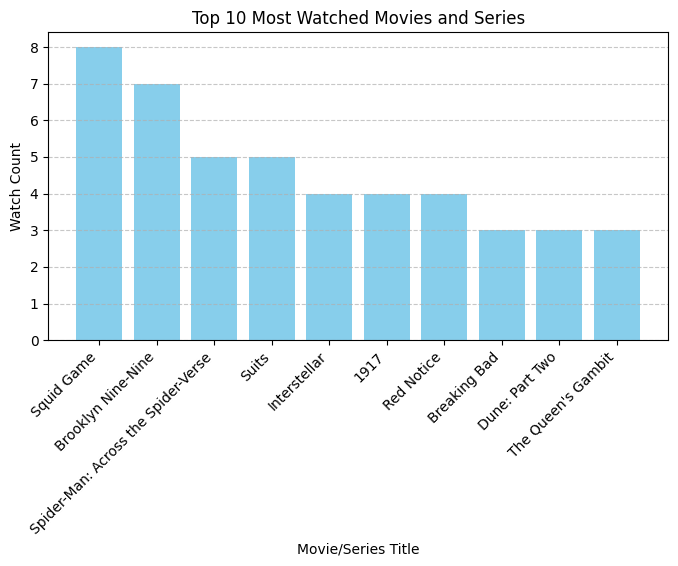

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(ALL_USERS_DATA_FILE)

title_counts = df['title'].value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.bar(title_counts.index, title_counts.values, color='skyblue')
plt.xlabel("Movie/Series Title")
plt.ylabel("Watch Count")
plt.title("Top 10 Most Watched Movies and Series")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-18-63eb82889198>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='username', y='rating', data=squid_game_data, palette="coolwarm")


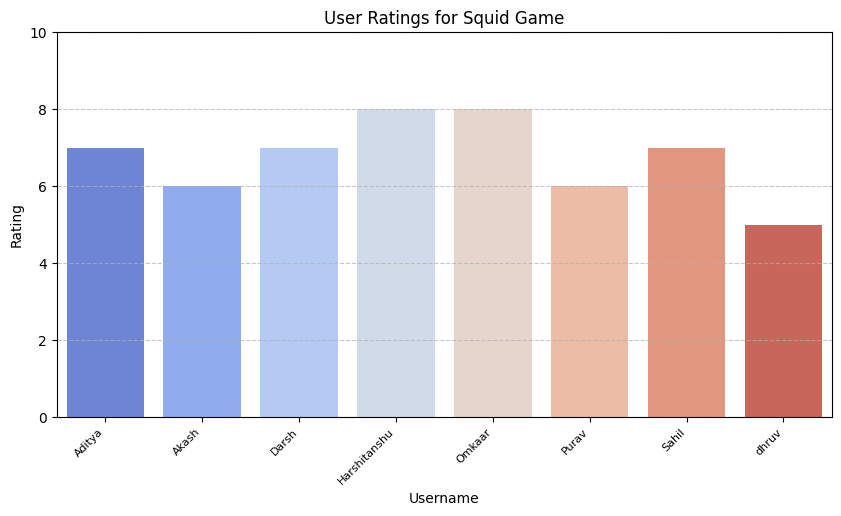

In [ ]:
# numeric 'Rating'
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Filter ratings for "Squid Game"
squid_game_data = df[df['title'] == "Squid Game"][['username', 'rating']].dropna()

# Sort users by rating
squid_game_data = squid_game_data.sort_values(by='username')

# Plot vertical bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='username', y='rating', data=squid_game_data, palette="coolwarm")

# Titles and labels
plt.title("User Ratings for Squid Game")
plt.xlabel("Username")
plt.ylabel("Rating")

plt.ylim(0, 10)  # Assuming ratings are between 0-10
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

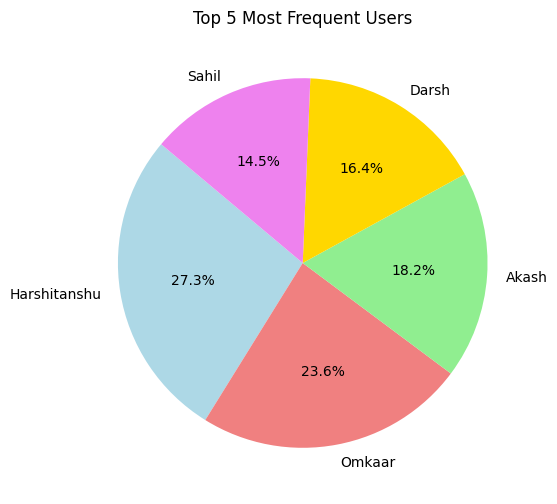

In [ ]:
# Count occurrences of each username
username_counts = df['username'].value_counts().head(5)  # Top 5 most frequent users

plt.figure(figsize=(6, 6))
plt.pie(username_counts, labels=username_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'violet'], startangle=140)
plt.title("Top 5 Most Frequent Users")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


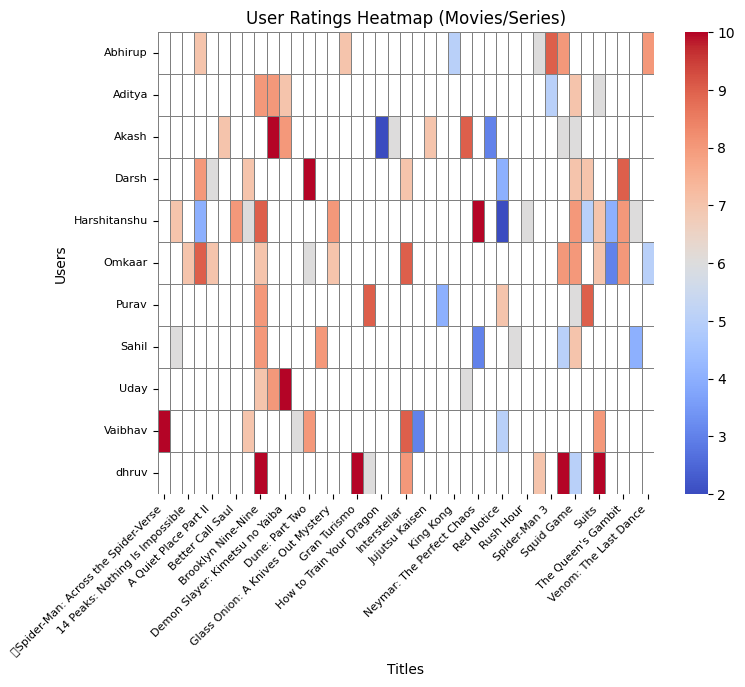

In [ ]:
# numeric 'Rating
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Create a pivot table: Users vs. Titles
heatmap_data = df.pivot_table(index='username', columns='title', values='rating', aggfunc='mean')

# Replace 0 values with NaN
heatmap_data.replace(0, np.nan, inplace=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, fmt=".1f", linewidths=0.5, linecolor='gray', cbar=True)

# Titles and labels
plt.title("User Ratings Heatmap (Movies/Series)")
plt.xlabel("Titles")
plt.ylabel("Users")

plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis for readability
plt.yticks(fontsize=8)

plt.show()